In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/braintumor.zip -d /content/braintumordataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/braintumordataset/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/braintumordataset/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/braintumordataset/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/braintumordataset/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/braintumordataset/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/braintumordataset/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/braintumordataset/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/braintumordataset/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/braintumordataset/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/braintumordataset/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/braintumordataset/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/braintumordataset/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/braintumordataset/Training/glioma/Tr-gl_0724.jpg  


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Constants
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32
EPOCHS = 15  # Increased epochs
TRAIN_PATH = 'braintumordataset/Training'
VALID_PATH = 'braintumordataset/Testing'

# Load the DenseNet121 model
densenet = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze the pre-trained layers
for layer in densenet.layers:
    layer.trainable = False

# Get the number of output classes
folders = glob(f'{TRAIN_PATH}/*')

# Add custom layers on top of the pre-trained model
x = GlobalAveragePooling2D()(densenet.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(len(folders), activation='softmax')(x)

# Create a model object
model = Model(inputs=densenet.input, outputs=prediction)

# View the structure of the model
model.summary()





29084464/29084464 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

In [4]:
# Compile the model with class weights
class_weights = {0: 1., 1: 1., 2: 1., 3: 1.}  # Adjust weights as needed
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create training and validation generators
training_set = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_set = test_datagen.flow_from_directory(
    VALID_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [5]:
# Train the model with callbacks
history = model.fit(
    training_set,
    validation_data=test_set,
    epochs=EPOCHS,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set),
    class_weight=class_weights,  # Use class weights
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/15
179/179 [==============================] - 112s 544ms/step - loss: 0.8827 - accuracy: 0.6483 - val_loss: 0.5434 - val_accuracy: 0.8040 - lr: 1.0000e-04
Epoch 2/15
179/179 [==============================] - 92s 515ms/step - loss: 0.5370 - accuracy: 0.7969 - val_loss: 0.5171 - val_accuracy: 0.8124 - lr: 1.0000e-04
Epoch 3/15
179/179 [==============================] - 92s 510ms/step - loss: 0.4501 - accuracy: 0.8302 - val_loss: 0.5202 - val_accuracy: 0.8032 - lr: 1.0000e-04
Epoch 4/15
179/179 [==============================] - 91s 510ms/step - loss: 0.4245 - accuracy: 0.8437 - val_loss: 0.4640 - val_accuracy: 0.8139 - lr: 1.0000e-04
Epoch 5/15
179/179 [==============================] - 92s 512ms/step - loss: 0.3853 - accuracy: 0.8601 - val_loss: 0.4489 - val_accuracy: 0.8360 - lr: 1.0000e-04
Epoch 6/15
179/179 [==============================] - 90s 502ms/step - loss: 0.3655 - accuracy: 0.8654 - val_loss: 0.4527 - val_accuracy: 0.8307 - lr: 1.0000e-04
Epoch 7/15
179/179 [=======

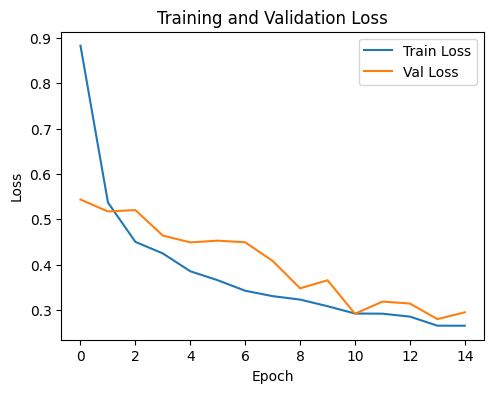

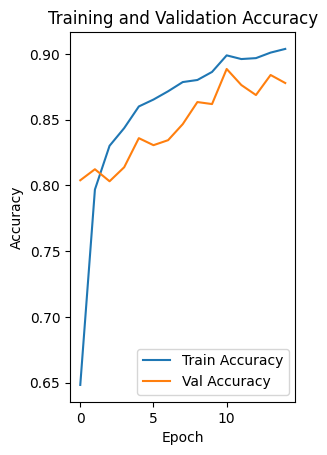

In [6]:
# Plotting Loss and Accuracy
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('DenseNet_LossVal_loss.png')
plt.show()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('DenseNet_AccVal_acc.png')
plt.show()


In [7]:
model.save('/content/drive/MyDrive/DenseNetaccuracy')

In [8]:
y_pred_probs = model.predict(test_set)
y_pred = np.argmax(y_pred_probs, axis=-1)

# Get the true labels from the test generator
y_test_labels = test_set.classes

# Get the class labels
labels = list(training_set.class_indices.keys())

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(y_test_labels, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(y_test_labels, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(y_test_labels, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred, target_names=labels))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred))


41/41 [==============================] - 7s 116ms/step
Accuracy: 0.8780
Precision: 0.8821
Recall: 0.8780
F1 Score: 0.8751

Classification Report:
              precision    recall  f1-score   support

      glioma       0.96      0.80      0.87       300
  meningioma       0.82      0.72      0.77       306
     notumor       0.92      0.97      0.94       405
   pituitary       0.82      1.00      0.90       300

    accuracy                           0.88      1311
   macro avg       0.88      0.87      0.87      1311
weighted avg       0.88      0.88      0.88      1311


Confusion Matrix:
[[239  41   1  19]
 [  6 220  33  47]
 [  4   7 392   2]
 [  0   0   0 300]]
